In [1]:
import os
import cv2
import shutil
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [2]:
# Define image transformations
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Download and load the dataset
dataset = CIFAR10(root='data/', download=True, transform=transform)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 61.7MB/s] 


Extracting data/cifar-10-python.tar.gz to data/


In [3]:
#GENERATOR

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(100 + 256, 4 * 4 * 512)
        )
        
        self.net = nn.Sequential(
            nn.BatchNorm2d(512, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, noise, text_input):
        text_emb = self.text_emb(text_input)
        x = torch.cat([noise, text_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = self.net(x)
        return x


In [4]:
#DISCRIMINATOR

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.image_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.final_net = nn.Sequential(
            nn.Conv2d(512 + 256, 512, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, image_input, text_input):
        text_emb = self.text_emb(text_input)
        text_emb = text_emb.view(-1, 256, 1, 1)
        text_emb = text_emb.repeat(1, 1, 4, 4)  # Tile to match image feature map size
        image_feat = self.image_net(image_input)
        combined = torch.cat([image_feat, text_emb], dim=1)
        output = self.final_net(combined)
        return output


In [5]:
# Loss function
criterion = nn.BCELoss()

# Create instances of the models
generator = Generator()
discriminator = Discriminator()

# Optimizers
lr = 0.0002
beta1 = 0.5
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)


Discriminator(
  (text_emb): Sequential(
    (0): Linear(in_features=119, out_features=256, bias=True)
    (1): ReLU()
  )
  (image_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (final_net): Sequential(
    (0): Conv2d(768, 512, kernel

In [7]:
def train_dcgan(num_epochs):
    generator.train()
    discriminator.train()
    total_step = len(dataloader)
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            batch_size_curr = images.size(0)
            images = images.to(device)
            
            # Labels
            real_labels = torch.ones(batch_size_curr, 1).to(device)
            fake_labels = torch.zeros(batch_size_curr, 1).to(device)
            
            # Text embeddings (random for now)
            text_inputs = torch.randn(batch_size_curr, 119).to(device)
            
            # =======================
            # Train Discriminator
            # =======================
            discriminator.zero_grad()
            
            # Real images
            outputs = discriminator(images, text_inputs)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            # Fake images
            noise = torch.randn(batch_size_curr, 100).to(device)
            fake_images = generator(noise, text_inputs)
            outputs = discriminator(fake_images.detach(), text_inputs)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # =======================
            # Train Generator
            # =======================
            generator.zero_grad()
            
            # Generate fake images
            outputs = discriminator(fake_images, text_inputs)
            g_loss = criterion(outputs, real_labels)
            
            # Backprop and optimize
            g_loss.backward()
            g_optimizer.step()
            
            # Print log info
            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
        
        # Save generated images
        save_fake_images(epoch+1)


In [8]:
def save_fake_images(epoch):
    generator.eval()
    with torch.no_grad():
        fixed_noise = torch.randn(64, 100).to(device)
        fixed_text = torch.randn(64, 119).to(device)
        fake_images = generator(fixed_noise, fixed_text)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]
        save_image(fake_images, f'fake_images_epoch_{epoch}.png', nrow=8)
    generator.train()


In [9]:
num_epochs = 50
train_dcgan(num_epochs)


Epoch [1/50], Step [200/782], D Loss: 0.5882, G Loss: 4.9677
Epoch [1/50], Step [400/782], D Loss: 0.1236, G Loss: 4.5130
Epoch [1/50], Step [600/782], D Loss: 0.3597, G Loss: 3.6093
Epoch [2/50], Step [200/782], D Loss: 1.7108, G Loss: 9.4907
Epoch [2/50], Step [400/782], D Loss: 0.6267, G Loss: 5.9009
Epoch [2/50], Step [600/782], D Loss: 1.2231, G Loss: 6.3266
Epoch [3/50], Step [200/782], D Loss: 0.3263, G Loss: 3.6222
Epoch [3/50], Step [400/782], D Loss: 0.6210, G Loss: 5.5238
Epoch [3/50], Step [600/782], D Loss: 0.3057, G Loss: 5.3675
Epoch [4/50], Step [200/782], D Loss: 0.1480, G Loss: 3.8665
Epoch [4/50], Step [400/782], D Loss: 0.5061, G Loss: 6.3665
Epoch [4/50], Step [600/782], D Loss: 0.6136, G Loss: 7.2720
Epoch [5/50], Step [200/782], D Loss: 0.2603, G Loss: 4.5811
Epoch [5/50], Step [400/782], D Loss: 1.1989, G Loss: 3.9120
Epoch [5/50], Step [600/782], D Loss: 0.2853, G Loss: 4.5387
Epoch [6/50], Step [200/782], D Loss: 0.4171, G Loss: 3.6149
Epoch [6/50], Step [400/

In [15]:
training_output = """
Epoch [1/50], Step [200/782], D Loss: 0.5882, G Loss: 4.9677
Epoch [1/50], Step [400/782], D Loss: 0.1236, G Loss: 4.5130
Epoch [1/50], Step [600/782], D Loss: 0.3597, G Loss: 3.6093
Epoch [2/50], Step [200/782], D Loss: 1.7108, G Loss: 9.4907
Epoch [2/50], Step [400/782], D Loss: 0.6267, G Loss: 5.9009
Epoch [2/50], Step [600/782], D Loss: 1.2231, G Loss: 6.3266
Epoch [3/50], Step [200/782], D Loss: 0.3263, G Loss: 3.6222
Epoch [3/50], Step [400/782], D Loss: 0.6210, G Loss: 5.5238
Epoch [3/50], Step [600/782], D Loss: 0.3057, G Loss: 5.3675
Epoch [4/50], Step [200/782], D Loss: 0.1480, G Loss: 3.8665
Epoch [4/50], Step [400/782], D Loss: 0.5061, G Loss: 6.3665
Epoch [4/50], Step [600/782], D Loss: 0.6136, G Loss: 7.2720
Epoch [5/50], Step [200/782], D Loss: 0.2603, G Loss: 4.5811
Epoch [5/50], Step [400/782], D Loss: 1.1989, G Loss: 3.9120
Epoch [5/50], Step [600/782], D Loss: 0.2853, G Loss: 4.5387
Epoch [6/50], Step [200/782], D Loss: 0.4171, G Loss: 3.6149
Epoch [6/50], Step [400/782], D Loss: 1.4551, G Loss: 2.5028
Epoch [6/50], Step [600/782], D Loss: 0.1706, G Loss: 5.3505
Epoch [7/50], Step [200/782], D Loss: 0.0959, G Loss: 4.6882
Epoch [7/50], Step [400/782], D Loss: 0.3499, G Loss: 3.7172
Epoch [7/50], Step [600/782], D Loss: 0.2908, G Loss: 4.1533
Epoch [8/50], Step [200/782], D Loss: 0.1249, G Loss: 4.6006
Epoch [8/50], Step [400/782], D Loss: 0.3709, G Loss: 6.1398
Epoch [8/50], Step [600/782], D Loss: 1.1962, G Loss: 1.5649
Epoch [9/50], Step [200/782], D Loss: 1.4628, G Loss: 1.6576
Epoch [9/50], Step [400/782], D Loss: 3.1097, G Loss: 6.9113
Epoch [9/50], Step [600/782], D Loss: 0.2918, G Loss: 5.4588
Epoch [10/50], Step [200/782], D Loss: 0.2582, G Loss: 4.1226
Epoch [10/50], Step [400/782], D Loss: 2.1221, G Loss: 4.7038
Epoch [10/50], Step [600/782], D Loss: 0.8590, G Loss: 7.3444
Epoch [11/50], Step [200/782], D Loss: 2.3172, G Loss: 0.0818
Epoch [11/50], Step [400/782], D Loss: 0.2997, G Loss: 4.9930
Epoch [11/50], Step [600/782], D Loss: 0.3262, G Loss: 2.9133
Epoch [12/50], Step [200/782], D Loss: 0.1567, G Loss: 5.3804
Epoch [12/50], Step [400/782], D Loss: 0.1147, G Loss: 4.4140
Epoch [12/50], Step [600/782], D Loss: 0.0807, G Loss: 5.4296
Epoch [13/50], Step [200/782], D Loss: 0.0975, G Loss: 5.6354
Epoch [13/50], Step [400/782], D Loss: 0.6612, G Loss: 10.8459
Epoch [13/50], Step [600/782], D Loss: 0.1688, G Loss: 5.2439
Epoch [14/50], Step [200/782], D Loss: 0.3121, G Loss: 4.6916
Epoch [14/50], Step [400/782], D Loss: 0.6458, G Loss: 13.0667
Epoch [14/50], Step [600/782], D Loss: 0.0467, G Loss: 4.5588
Epoch [15/50], Step [200/782], D Loss: 0.1971, G Loss: 4.7985
Epoch [15/50], Step [400/782], D Loss: 0.0139, G Loss: 8.6317
Epoch [15/50], Step [600/782], D Loss: 0.0114, G Loss: 4.4415
Epoch [16/50], Step [200/782], D Loss: 0.0563, G Loss: 8.3636
Epoch [16/50], Step [400/782], D Loss: 0.0223, G Loss: 8.9502
Epoch [16/50], Step [600/782], D Loss: 0.0424, G Loss: 5.5957
Epoch [17/50], Step [200/782], D Loss: 0.0924, G Loss: 4.9772
Epoch [17/50], Step [400/782], D Loss: 1.4006, G Loss: 11.0005
Epoch [17/50], Step [600/782], D Loss: 0.1493, G Loss: 7.3821
Epoch [18/50], Step [200/782], D Loss: 0.0952, G Loss: 5.4071
Epoch [18/50], Step [400/782], D Loss: 0.4967, G Loss: 12.3638
Epoch [18/50], Step [600/782], D Loss: 0.0504, G Loss: 5.0355
Epoch [19/50], Step [200/782], D Loss: 0.1759, G Loss: 4.7224
Epoch [19/50], Step [400/782], D Loss: 0.2275, G Loss: 5.9743
Epoch [19/50], Step [600/782], D Loss: 0.0841, G Loss: 4.5375
Epoch [20/50], Step [200/782], D Loss: 0.3067, G Loss: 7.1875
Epoch [20/50], Step [400/782], D Loss: 0.0323, G Loss: 6.4598
Epoch [20/50], Step [600/782], D Loss: 0.3404, G Loss: 7.0464
Epoch [21/50], Step [200/782], D Loss: 0.1214, G Loss: 5.5765
Epoch [21/50], Step [400/782], D Loss: 0.0175, G Loss: 6.2691
Epoch [21/50], Step [600/782], D Loss: 0.0454, G Loss: 9.0800
Epoch [22/50], Step [200/782], D Loss: 0.0420, G Loss: 6.1244
Epoch [22/50], Step [400/782], D Loss: 0.1047, G Loss: 6.5454
Epoch [22/50], Step [600/782], D Loss: 0.2692, G Loss: 10.1900
Epoch [23/50], Step [200/782], D Loss: 0.0820, G Loss: 5.1898
Epoch [23/50], Step [400/782], D Loss: 0.0298, G Loss: 6.4626
Epoch [23/50], Step [600/782], D Loss: 0.5184, G Loss: 11.0821
Epoch [24/50], Step [200/782], D Loss: 0.1541, G Loss: 7.6890
Epoch [24/50], Step [400/782], D Loss: 0.1435, G Loss: 4.3599
Epoch [24/50], Step [600/782], D Loss: 0.1529, G Loss: 5.4768
Epoch [25/50], Step [200/782], D Loss: 0.3580, G Loss: 4.4794
Epoch [25/50], Step [400/782], D Loss: 0.0702, G Loss: 6.8052
Epoch [25/50], Step [600/782], D Loss: 0.0722, G Loss: 5.5817
Epoch [26/50], Step [200/782], D Loss: 0.3814, G Loss: 4.4501
Epoch [26/50], Step [400/782], D Loss: 0.0304, G Loss: 6.1391
Epoch [26/50], Step [600/782], D Loss: 0.2492, G Loss: 7.4929
Epoch [27/50], Step [200/782], D Loss: 0.0774, G Loss: 7.7825
Epoch [27/50], Step [400/782], D Loss: 0.0322, G Loss: 6.8442
Epoch [27/50], Step [600/782], D Loss: 0.0633, G Loss: 5.4406
Epoch [28/50], Step [200/782], D Loss: 0.0456, G Loss: 5.6254
Epoch [28/50], Step [400/782], D Loss: 0.1621, G Loss: 3.7664
Epoch [28/50], Step [600/782], D Loss: 0.0598, G Loss: 5.5844
Epoch [29/50], Step [200/782], D Loss: 0.0874, G Loss: 5.2709
Epoch [29/50], Step [400/782], D Loss: 0.1309, G Loss: 6.1853
Epoch [29/50], Step [600/782], D Loss: 0.0840, G Loss: 6.9478
Epoch [30/50], Step [200/782], D Loss: 0.0096, G Loss: 7.4065
Epoch [30/50], Step [400/782], D Loss: 0.1475, G Loss: 11.3817
Epoch [30/50], Step [600/782], D Loss: 0.0473, G Loss: 5.7558
Epoch [31/50], Step [200/782], D Loss: 0.2224, G Loss: 5.0819
Epoch [31/50], Step [400/782], D Loss: 0.2023, G Loss: 8.9251
Epoch [31/50], Step [600/782], D Loss: 0.1855, G Loss: 9.3141
Epoch [32/50], Step [200/782], D Loss: 0.2130, G Loss: 4.3245
Epoch [32/50], Step [400/782], D Loss: 0.0398, G Loss: 6.6641
Epoch [32/50], Step [600/782], D Loss: 0.1339, G Loss: 5.9674
Epoch [33/50], Step [200/782], D Loss: 0.1240, G Loss: 8.7811
Epoch [33/50], Step [400/782], D Loss: 0.5084, G Loss: 8.6487
Epoch [33/50], Step [600/782], D Loss: 0.0539, G Loss: 4.8600
Epoch [34/50], Step [200/782], D Loss: 0.0105, G Loss: 10.4320
Epoch [34/50], Step [400/782], D Loss: 0.0169, G Loss: 22.7502
Epoch [34/50], Step [600/782], D Loss: 0.1609, G Loss: 13.2266
Epoch [35/50], Step [200/782], D Loss: 0.0215, G Loss: 7.8999
Epoch [35/50], Step [400/782], D Loss: 0.0162, G Loss: 5.3771
Epoch [35/50], Step [600/782], D Loss: 0.0095, G Loss: 11.0147
Epoch [36/50], Step [200/782], D Loss: 0.1534, G Loss: 7.9254
Epoch [36/50], Step [400/782], D Loss: 0.0569, G Loss: 6.4671
Epoch [36/50], Step [600/782], D Loss: 0.0073, G Loss: 9.8693
Epoch [37/50], Step [200/782], D Loss: 0.1536, G Loss: 8.6811
Epoch [37/50], Step [400/782], D Loss: 0.0126, G Loss: 7.2708
Epoch [37/50], Step [600/782], D Loss: 0.0824, G Loss: 8.5958
Epoch [38/50], Step [200/782], D Loss: 0.0943, G Loss: 6.7994
Epoch [38/50], Step [400/782], D Loss: 0.0187, G Loss: 9.1459
Epoch [38/50], Step [600/782], D Loss: 0.5165, G Loss: 5.5227
Epoch [39/50], Step [200/782], D Loss: 0.1760, G Loss: 5.0129
Epoch [39/50], Step [400/782], D Loss: 0.0386, G Loss: 6.2528
Epoch [39/50], Step [600/782], D Loss: 2.2467, G Loss: 14.1053
Epoch [40/50], Step [200/782], D Loss: 0.0466, G Loss: 5.3832
Epoch [40/50], Step [400/782], D Loss: 0.0330, G Loss: 15.0983
Epoch [40/50], Step [600/782], D Loss: 0.0010, G Loss: 9.7734
Epoch [41/50], Step [200/782], D Loss: 0.0020, G Loss: 7.2627
Epoch [41/50], Step [400/782], D Loss: 0.4300, G Loss: 12.9372
Epoch [41/50], Step [600/782], D Loss: 0.1559, G Loss: 7.7523
Epoch [42/50], Step [200/782], D Loss: 0.0635, G Loss: 6.9049
Epoch [42/50], Step [400/782], D Loss: 0.0739, G Loss: 7.0876
Epoch [42/50], Step [600/782], D Loss: 0.0233, G Loss: 6.5754
Epoch [43/50], Step [200/782], D Loss: 0.1480, G Loss: 7.4268
Epoch [43/50], Step [400/782], D Loss: 0.0328, G Loss: 6.1302
Epoch [43/50], Step [600/782], D Loss: 0.0623, G Loss: 11.9191
Epoch [44/50], Step [200/782], D Loss: 0.0185, G Loss: 6.8232
Epoch [44/50], Step [400/782], D Loss: 0.0202, G Loss: 6.6512
Epoch [44/50], Step [600/782], D Loss: 0.1899, G Loss: 11.3256
Epoch [45/50], Step [200/782], D Loss: 0.0014, G Loss: 9.4797
Epoch [45/50], Step [400/782], D Loss: 0.1644, G Loss: 4.5540
Epoch [45/50], Step [600/782], D Loss: 0.0202, G Loss: 6.4972
Epoch [46/50], Step [200/782], D Loss: 0.3755, G Loss: 4.0012
Epoch [46/50], Step [400/782], D Loss: 0.0471, G Loss: 5.3814
Epoch [46/50], Step [600/782], D Loss: 0.2134, G Loss: 4.6708
Epoch [47/50], Step [200/782], D Loss: 0.0524, G Loss: 7.1227
Epoch [47/50], Step [400/782], D Loss: 0.0374, G Loss: 7.0785
Epoch [47/50], Step [600/782], D Loss: 0.0252, G Loss: 6.4938
Epoch [48/50], Step [200/782], D Loss: 0.0858, G Loss: 10.0585
Epoch [48/50], Step [400/782], D Loss: 0.0095, G Loss: 6.5933
Epoch [48/50], Step [600/782], D Loss: 0.0033, G Loss: 10.1723
Epoch [49/50], Step [200/782], D Loss: 0.1514, G Loss: 16.0717
Epoch [49/50], Step [400/782], D Loss: 0.0521, G Loss: 5.7519
Epoch [49/50], Step [600/782], D Loss: 0.1356, G Loss: 5.0471
Epoch [50/50], Step [200/782], D Loss: 0.0118, G Loss: 9.4535
Epoch [50/50], Step [400/782], D Loss: 0.0252, G Loss: 6.2002
Epoch [50/50], Step [600/782], D Loss: 0.0675, G Loss: 5.8600
"""


In [16]:
import re

# Initialize lists to store losses
losses_d = []
losses_g = []

# Split the output into lines
lines = training_output.strip().split('\n')

for line in lines:
    # Use regular expressions to extract the loss values
    match = re.search(r'D Loss: ([0-9\.]+), G Loss: ([0-9\.]+)', line)
    if match:
        d_loss = float(match.group(1))
        g_loss = float(match.group(2))
        losses_d.append(d_loss)
        losses_g.append(g_loss)


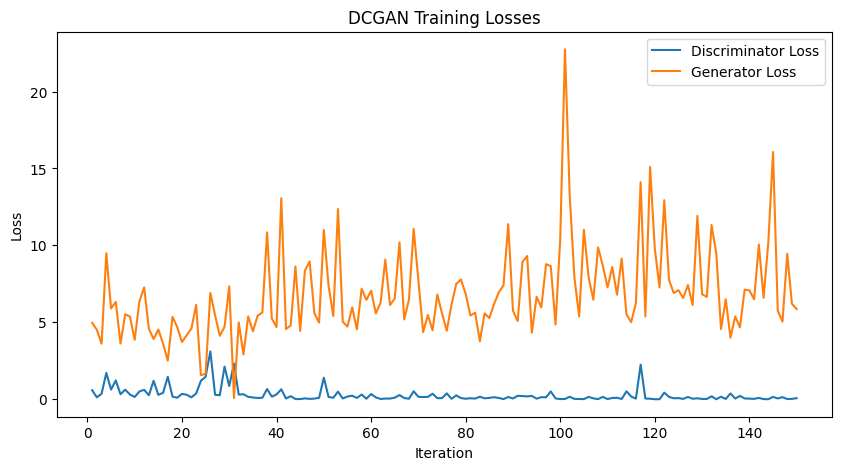

In [17]:
import matplotlib.pyplot as plt

# Create a list of iterations (assuming each print corresponds to an iteration)
iterations = list(range(1, len(losses_d) + 1))

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses_d, label='Discriminator Loss')
plt.plot(iterations, losses_g, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('DCGAN Training Losses')
plt.legend()
plt.show()
